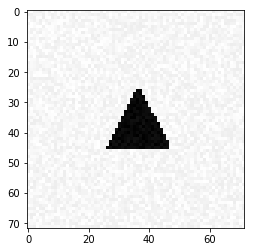

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


In [245]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape, Flatten, Dropout, UpSampling2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils

from keras.optimizers import SGD, Adam


In [18]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
#X_train = (X_train - np.mean(X_train))/np.std(X_train)
Y_train = np_utils.to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [19]:
model = Sequential([
    Dense(3, input_shape=(5184,), activation= "sigmoid")
    ])

sgd = SGD(lr=0.001, decay=1e-5, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=["acc"])
model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 0.6384 - acc: 0.7033
Epoch 2/20
300/300 [==============================] - 0s 258us/step - loss: 0.2965 - acc: 0.9733
Epoch 3/20
300/300 [==============================] - 0s 254us/step - loss: 0.1557 - acc: 1.0000
Epoch 4/20
300/300 [==============================] - 0s 263us/step - loss: 0.0954 - acc: 1.0000
Epoch 5/20
300/300 [==============================] - 0s 253us/step - loss: 0.0690 - acc: 1.0000
Epoch 6/20
300/300 [==============================] - 0s 257us/step - loss: 0.0528 - acc: 1.0000
Epoch 7/20
300/300 [==============================] - 0s 263us/step - loss: 0.0438 - acc: 1.0000
Epoch 8/20
300/300 [==============================] - 0s 261us/step - loss: 0.0376 - acc: 1.0000
Epoch 9/20
300/300 [==============================] - 0s 258us/step - loss: 0.0332 - acc: 1.0000
Epoch 10/20
300/300 [==============================] - 0s 256us/step - loss: 0.0298 - acc: 1.0000
Epoch 11/20
300/300 [==========

In [23]:
from keras.optimizers import Adam

model = Sequential([
    Dense(3, input_shape=(5184,), activation= "sigmoid")
    ])

adam = Adam(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=["acc"])

model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 0s 1ms/step - loss: 0.4484 - acc: 0.8100
Epoch 2/10
300/300 [==============================] - 0s 148us/step - loss: 0.0899 - acc: 0.9789
Epoch 3/10
300/300 [==============================] - 0s 149us/step - loss: 0.0288 - acc: 1.0000
Epoch 4/10
300/300 [==============================] - 0s 159us/step - loss: 0.0143 - acc: 1.0000
Epoch 5/10
300/300 [==============================] - 0s 171us/step - loss: 0.0094 - acc: 1.0000
Epoch 6/10
300/300 [==============================] - 0s 157us/step - loss: 0.0067 - acc: 1.0000
Epoch 7/10
300/300 [==============================] - 0s 159us/step - loss: 0.0057 - acc: 1.0000
Epoch 8/10
300/300 [==============================] - 0s 158us/step - loss: 0.0049 - acc: 1.0000
Epoch 9/10
300/300 [==============================] - 0s 161us/step - loss: 0.0044 - acc: 1.0000
Epoch 10/10
300/300 [==============================] - 0s 159us/step - loss: 0.0040 - acc: 1.0000


In [24]:
X_test = generate_a_disk()/255
X_test = X_test.reshape(1, X_test.shape[0])

In [25]:
model.predict(X_test)

array([[5.7888301e-03, 9.9688077e-01, 4.1243152e-04]], dtype=float32)

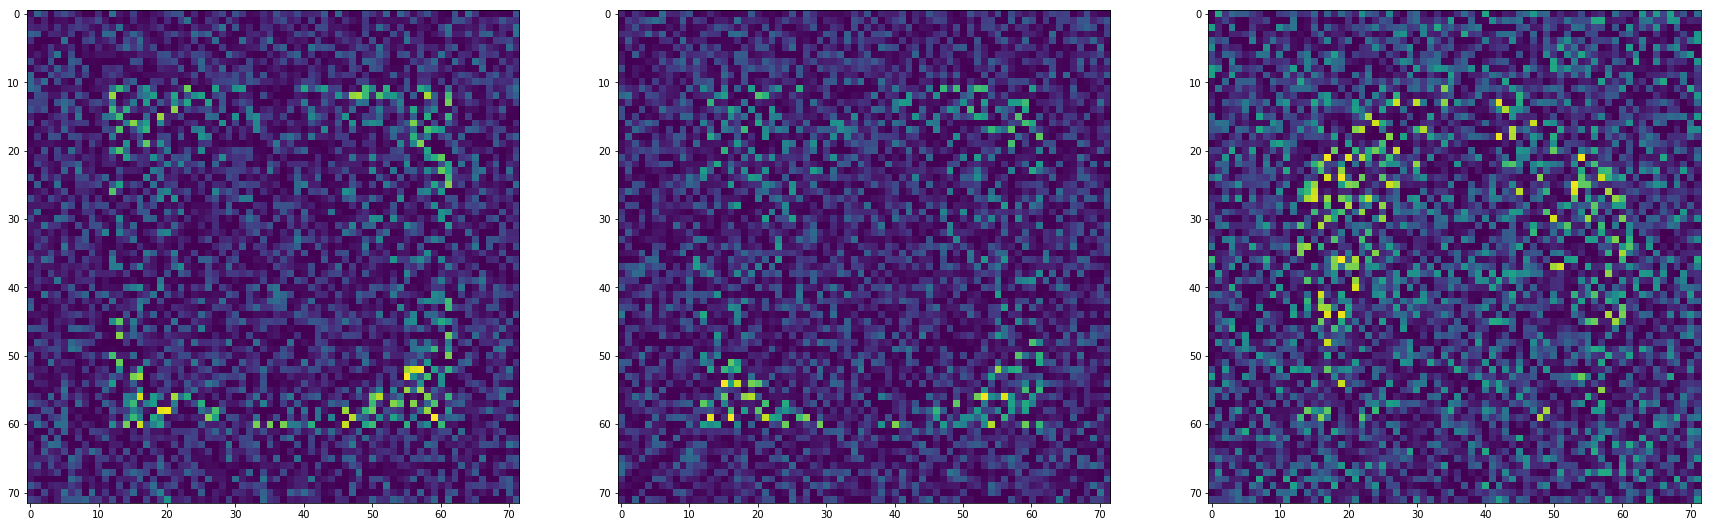

In [26]:
weights = model.get_weights()[0]
fig, ax = plt.subplots(1, 3, figsize = (30, 10))

for i in range(3):
    img = np.reshape(weights[:,i], (72, 72))**2
    ax[i].imshow(img)

In [24]:
weights[0].shape

(3,)

In [27]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train)

[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [30]:
from keras.optimizers import SGD

model = Sequential([
    Dense(3, input_shape=(5184,), activation= "sigmoid")
    ])

adam = Adam(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=["acc"])
model.fit(X_train, Y_train, epochs=20, batch_size=32, verbose = 1)

Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5260 - acc: 0.7444
Epoch 2/20
300/300 [==============================] - 0s 153us/step - loss: 0.0982 - acc: 1.0000
Epoch 3/20
300/300 [==============================] - 0s 162us/step - loss: 0.0326 - acc: 1.0000
Epoch 4/20
300/300 [==============================] - 0s 178us/step - loss: 0.0168 - acc: 1.0000
Epoch 5/20
300/300 [==============================] - 0s 175us/step - loss: 0.0107 - acc: 1.0000
Epoch 6/20
300/300 [==============================] - 0s 160us/step - loss: 0.0084 - acc: 1.0000
Epoch 7/20
300/300 [==============================] - 0s 166us/step - loss: 0.0071 - acc: 1.0000
Epoch 8/20
300/300 [==============================] - 0s 167us/step - loss: 0.0061 - acc: 1.0000
Epoch 9/20
300/300 [==============================] - 0s 155us/step - loss: 0.0055 - acc: 1.0000
Epoch 10/20
300/300 [==============================] - 0s 168us/step - loss: 0.0049 - acc: 1.0000
Epoch 11/20
300/300 [==========

In [31]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 692us/step


[0.002361936786522468, 1.0]

In [43]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train)

[X_test, Y_test] = generate_test_set_classification()
#Y_test = np_utils.to_categorical(Y_test)

X_train = np.reshape(X_train, (-1, 72, 72, 1))
X_test = np.reshape(X_test, (-1, 72, 72, 1))



Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [49]:
model_cnn = Sequential([
    Conv2D(16, (5, 5), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(3),
    ])

sgd = SGD(lr=0.001, decay=1e-5, momentum=0.9, nesterov=True)
adam = Adam(lr = 0.001, decay = 1e-5)
model_cnn.compile(loss='mean_squared_error',optimizer=adam, metrics=["acc"])
model_cnn.fit(X_train, Y_train, epochs=20, batch_size=32, verbose = 1)

Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2444 - acc: 0.7300
Epoch 2/20
300/300 [==============================] - 0s 404us/step - loss: 0.0331 - acc: 1.0000
Epoch 3/20
300/300 [==============================] - 0s 349us/step - loss: 0.0087 - acc: 1.0000
Epoch 4/20
300/300 [==============================] - 0s 328us/step - loss: 0.0050 - acc: 1.0000
Epoch 5/20
300/300 [==============================] - 0s 322us/step - loss: 0.0026 - acc: 1.0000
Epoch 6/20
300/300 [==============================] - 0s 299us/step - loss: 0.0018 - acc: 1.0000
Epoch 7/20
300/300 [==============================] - 0s 305us/step - loss: 0.0014 - acc: 1.0000
Epoch 8/20
300/300 [==============================] - 0s 308us/step - loss: 0.0011 - acc: 1.0000
Epoch 9/20
300/300 [==============================] - 0s 311us/step - loss: 0.0010 - acc: 1.0000
Epoch 10/20
300/300 [==============================] - 0s 326us/step - loss: 8.7345e-04 - acc: 1.0000
Epoch 11/20
300/300 [======

In [48]:
model_cnn.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 612us/step


[0.004516767278934518, 1.0]

In [35]:
X_test.shape

(300, 72, 72, 1)

In [36]:
X_train.shape

(300, 72, 72, 1)

In [119]:
def to_polar(Y_cart):
    Y_cart -= .5
    Y_pol = np.zeros_like(Y_cart)
    Y_pol[:, 0] = np.sqrt((Y_cart[:, 0])**2 + (Y_cart[:, 1])**2)
    Y_pol[:, 1] = np.sqrt((Y_cart[:, 2])**2 + (Y_cart[:, 3])**2)
    Y_pol[:, 2] = np.sqrt((Y_cart[:, 4])**2 + (Y_cart[:, 5])**2)
    Y_pol[:, 3] = np.arctan(Y_cart[:, 1]/Y_cart[:, 0])
    Y_pol[:, 4] = np.arctan(Y_cart[:, 3]/Y_cart[:, 2])
    Y_pol[:, 5] = np.arctan(Y_cart[:, 5]/Y_cart[:, 4])
    return Y_pol

def to_cart(Y_pol):
    Y_cart = np.zeros_like(Y_pol)
    Y_cart[:, 0] =  Y_pol[:, 0]*np.cos(Y_pol[:, 3])
    Y_cart[:, 1] =  Y_pol[:, 0]*np.sin(Y_pol[:, 3])
    Y_cart[:, 2] =  Y_pol[:, 1]*np.cos(Y_pol[:, 4])
    Y_cart[:, 3] =  Y_pol[:, 1]*np.sin(Y_pol[:, 4])
    Y_cart[:, 4] =  Y_pol[:, 2]*np.cos(Y_pol[:, 5])
    Y_cart[:, 5] =  Y_pol[:, 2]*np.sin(Y_pol[:, 5])
    Y_cart = 1 - Y_cart
    return Y_cart

In [38]:
Y_train.shape

(300, 3)

In [148]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [133]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [150]:
X_train_2D = np.reshape(X_train, (-1, 72, 72, 1))
X_test_2D = np.reshape(X_test, (-1, 72, 72, 1))

model = Sequential([
    Conv2D(10, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    #Dropout(0.9),
    Conv2D(20, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    #Dropout(0.0.),
    Flatten(),
    Dense(6),
    ])

In [151]:
from keras.optimizers import Adam

model = Sequential([
    Dense(20, input_shape=(5184,), activation = "relu"),
    Dense(6)
    ])

model = Sequential([
    Conv2D(10, (5, 5), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    #Dropout(0.9),
    #Dropout(0.0.),
    Flatten(),
    Dense(6),
    ])

adam = Adam(lr=0.001, decay=1e-3)
model.compile(loss='mean_squared_error',optimizer=adam)


model.fit(X_train_2D, Y_train, epochs=50, batch_size=32)

Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2280
Epoch 2/50
1000/1000 [==============================] - 0s 310us/step - loss: 0.0658
Epoch 3/50
1000/1000 [==============================] - 0s 297us/step - loss: 0.0544
Epoch 4/50
1000/1000 [==============================] - 0s 293us/step - loss: 0.0479
Epoch 5/50
1000/1000 [==============================] - 0s 301us/step - loss: 0.0429
Epoch 6/50
1000/1000 [==============================] - 0s 307us/step - loss: 0.0376
Epoch 7/50
1000/1000 [==============================] - 0s 306us/step - loss: 0.0338
Epoch 8/50
1000/1000 [==============================] - 0s 304us/step - loss: 0.0309
Epoch 9/50
1000/1000 [==============================] - 0s 318us/step - loss: 0.0283
Epoch 10/50
1000/1000 [==============================] - 0s 305us/step - loss: 0.0258
Epoch 11/50
1000/1000 [==============================] - 0s 297us/step - loss: 0.0234
Epoch 12/50
1000/1000 [==============================] - 0s 306us

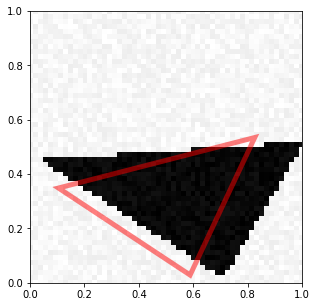

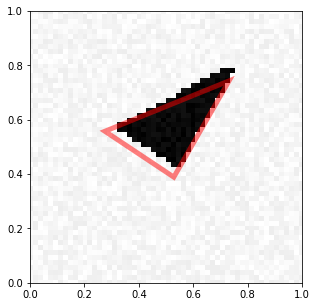

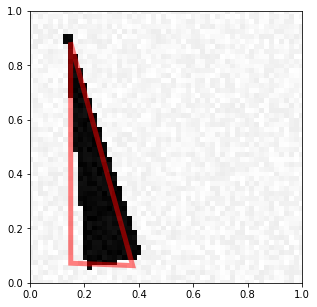

In [135]:
Y_predict = model.predict(X_train_2D)

for i in range(5,8):
    visualize_prediction(X_train[i], Y_predict[i])

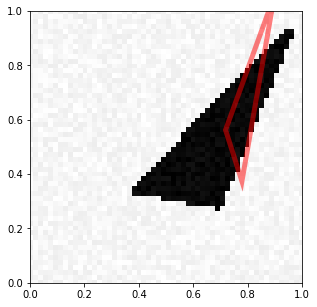

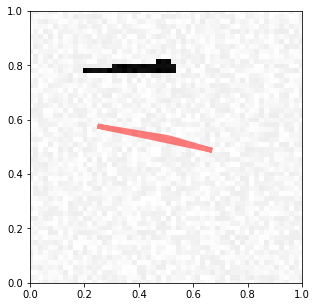

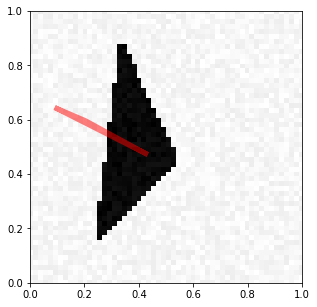

In [136]:
Y_predict = model.predict(X_test_2D)

for i in range(3):
    visualize_prediction(X_test[i], Y_predict[i])

In [131]:
Y_train

array([[-1.22516336, -0.82062102, -0.66458744, -0.86151817, -1.27291491,
        -1.04418081],
       [-0.89017462, -1.32544113, -0.89638238, -0.76652109, -1.12260136,
        -0.55673944],
       [-1.3916817 , -1.12892138, -1.45634837, -0.77098655, -0.87793301,
        -1.18780613],
       ...,
       [-0.63796501, -0.71726788, -0.79717477, -1.05659598, -1.04246515,
        -0.84118896],
       [-0.70612984, -1.47760783, -0.67505072, -1.2119313 , -1.1434062 ,
        -1.25105279],
       [-1.01498862, -0.74712608, -0.98163451, -1.48471851, -1.43001681,
        -0.89249615]])

In [139]:
 model.get_weights()[0].shape

(7, 7, 1, 100)

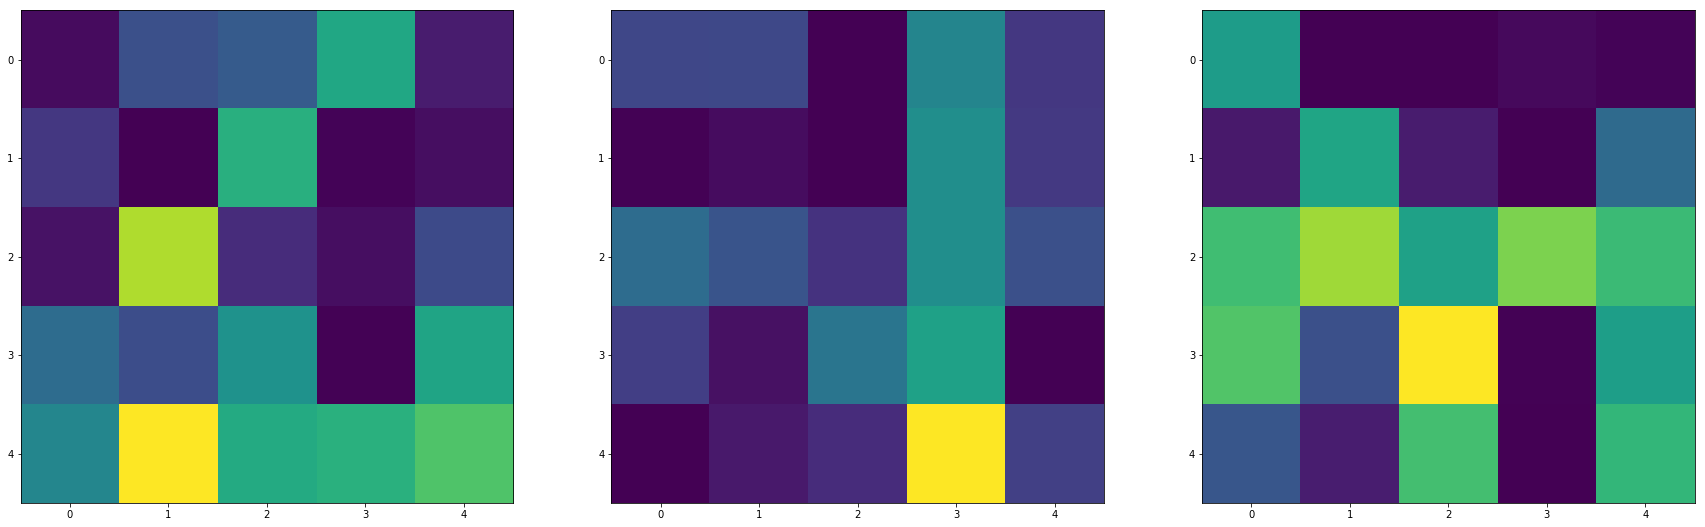

In [155]:
weights = model.get_weights()[0]
fig, ax = plt.subplots(1, 3, figsize = (30, 10))

for i in range(3):
    img = np.reshape(weights[:,:, 0, i+3], (5, 5))**2
    ax[i].imshow(img)

In [176]:
def generate_a_rectangle_2(noise=1.0, free_location=True):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)

def generate_dataset_denoising(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = 72*72
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_rectangle_2(noise, True)
    Y =  Y / 255 
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

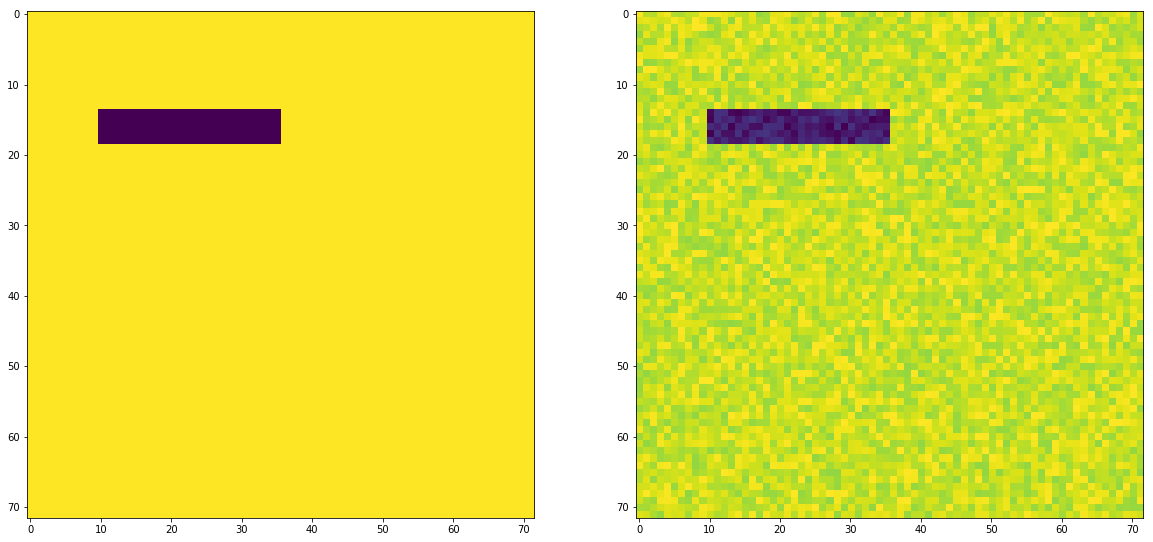

In [170]:
fig_clean, fig_noise = generate_a_rectangle_2(noise=50.0, free_location=True)

fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(np.reshape(fig_clean, (72, 72)))
ax[1].imshow(np.reshape(fig_noise, (72, 72)))

In [177]:
X_train, Y_train = generate_dataset_denoising(300, noise=50)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [178]:
X_test, Y_test = generate_dataset_denoising(300, noise=50)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [267]:
from keras.optimizers import Adam

model = Sequential([
    Reshape((72, 72, 1)),
    Conv2D(20, (3, 3), activation = "relu", padding = "same"),
    #Conv2D(20, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    #BatchNormalization(),
    Conv2D(40, (3, 3), activation = "relu", padding = "same"),
    #Conv2D(40, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    #BatchNormalization(),
    Conv2D(80, (3, 3), activation = "relu", padding = "same"),
    #Conv2D(80, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    #Flatten(),
    #Dense((72//8)*(72//8)*40,  activation = "relu"),
    #Reshape((72//8, 72//8, 40)),
    UpSampling2D((2,2)),
    #BatchNormalization(),
    Conv2DTranspose(80, (3, 3), activation = "relu", padding = "same"),
    UpSampling2D((2,2)),
    #BatchNormalization(),
    Conv2DTranspose(40, (3, 3), activation = "relu", padding = "same"),
    UpSampling2D((2,2)),
    #BatchNormalization(),
    Conv2DTranspose(20, (3, 3), activation = "relu", padding = "same"),
    Conv2DTranspose(10, (3, 3), activation = "relu", padding = "same"),
    Conv2DTranspose(1, (5, 5), activation = "relu", padding = "same"),
    Reshape((72*72,))
    ])


adam = Adam(lr=0.001, decay=1e-3)
model.compile(loss='mean_squared_error',optimizer=adam) 


#model.output_shape
model.fit(X_train, Y_train, epochs=500, batch_size=16)

Epoch 1/500
300/300 [==============================] - 7s 24ms/step - loss: 0.3322
Epoch 2/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0576
Epoch 3/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0268
Epoch 4/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0175
Epoch 5/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 6/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0113
Epoch 7/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0096
Epoch 8/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0082
Epoch 9/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 10/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0060
Epoch 11/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 12/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 13/500

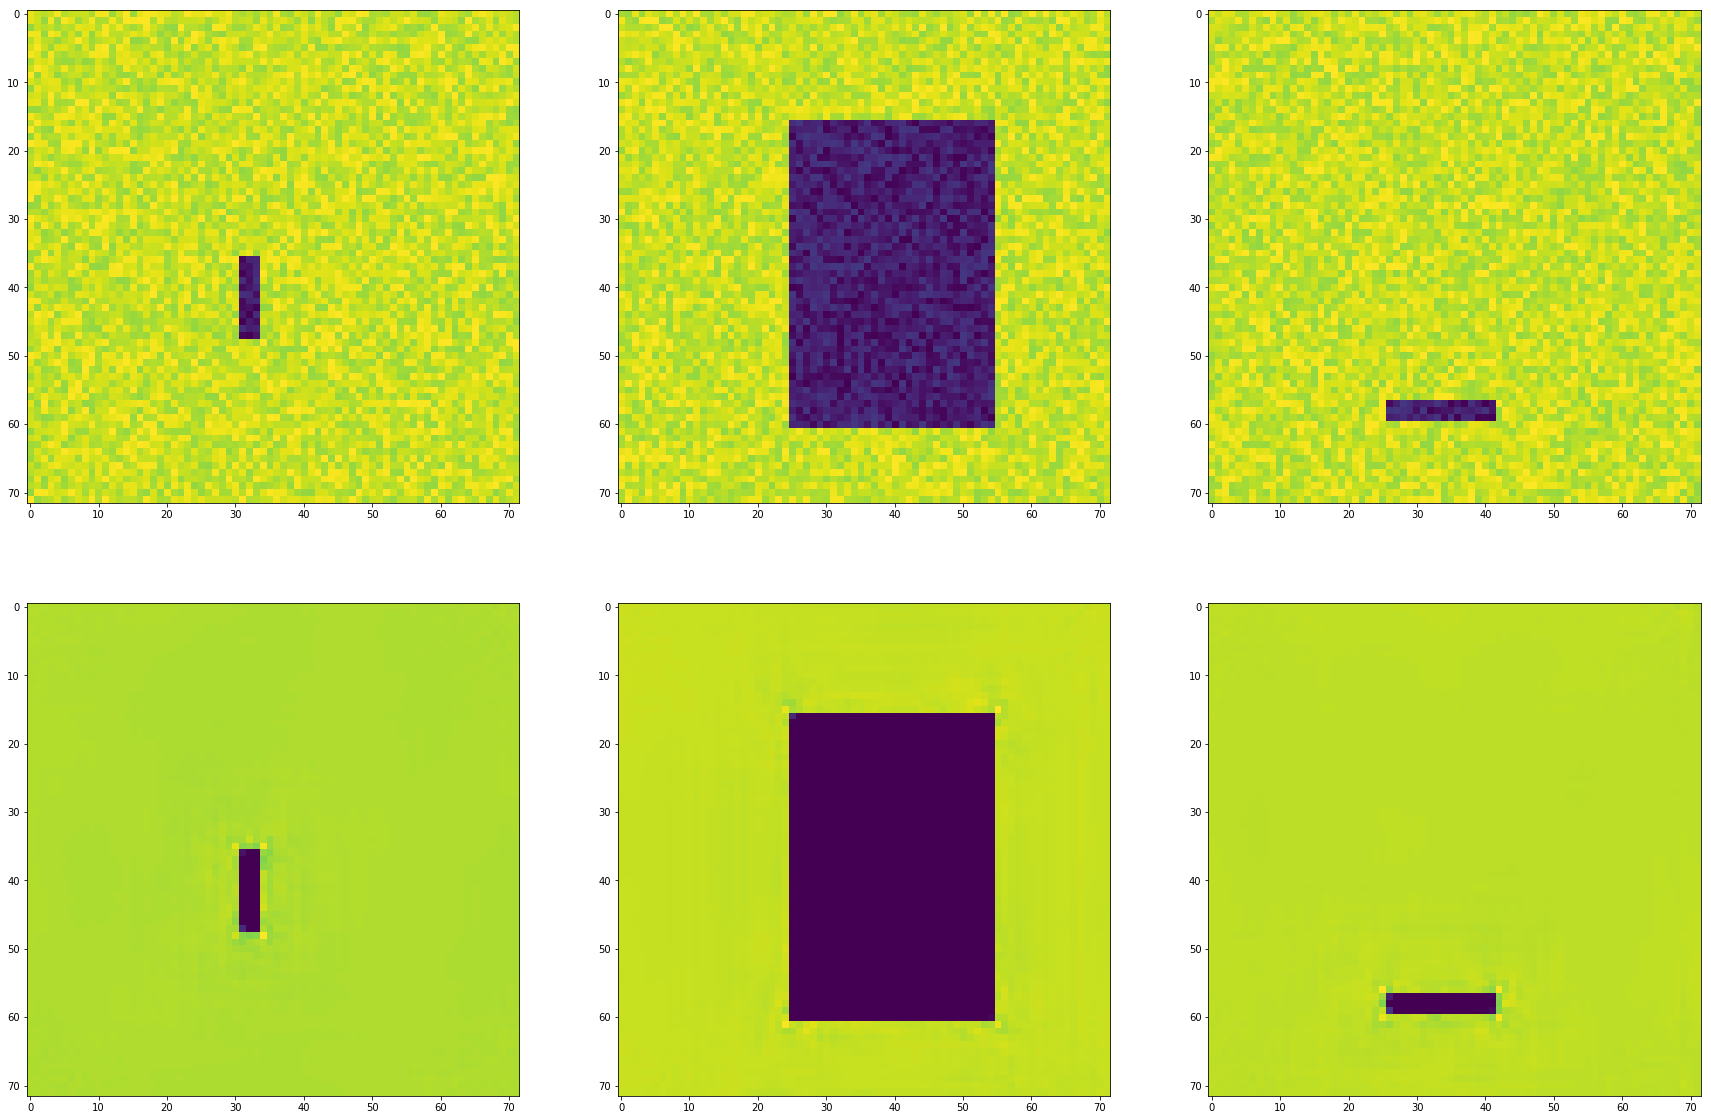

In [268]:
fig, ax = plt.subplots(2, 3, figsize = (30, 20))

for i in range(3):
    ax[0][i].imshow(np.reshape(X_train[i], (72, 72)))
    ax[1][i].imshow(np.reshape(model.predict(X_train[i][None]), (72, 72)))

In [270]:
np.min(model.predict(X_train[0][None]))

0.0

In [183]:
X_train[i].shape

(5184,)